In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.observation_space)
print(env.action_space)
print(env.action_space.n)
print(env.action_space.sample())


Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)
2
0


In [5]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [6]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))

[((15, 3, False), 1, -1)]
[((20, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
[((21, 5, True), 0, 1.0)]


In [7]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    state = env.reset()
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**n for n in range(len(rewards)+1)])
        
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[(1+i):])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Episode 500000/500000.

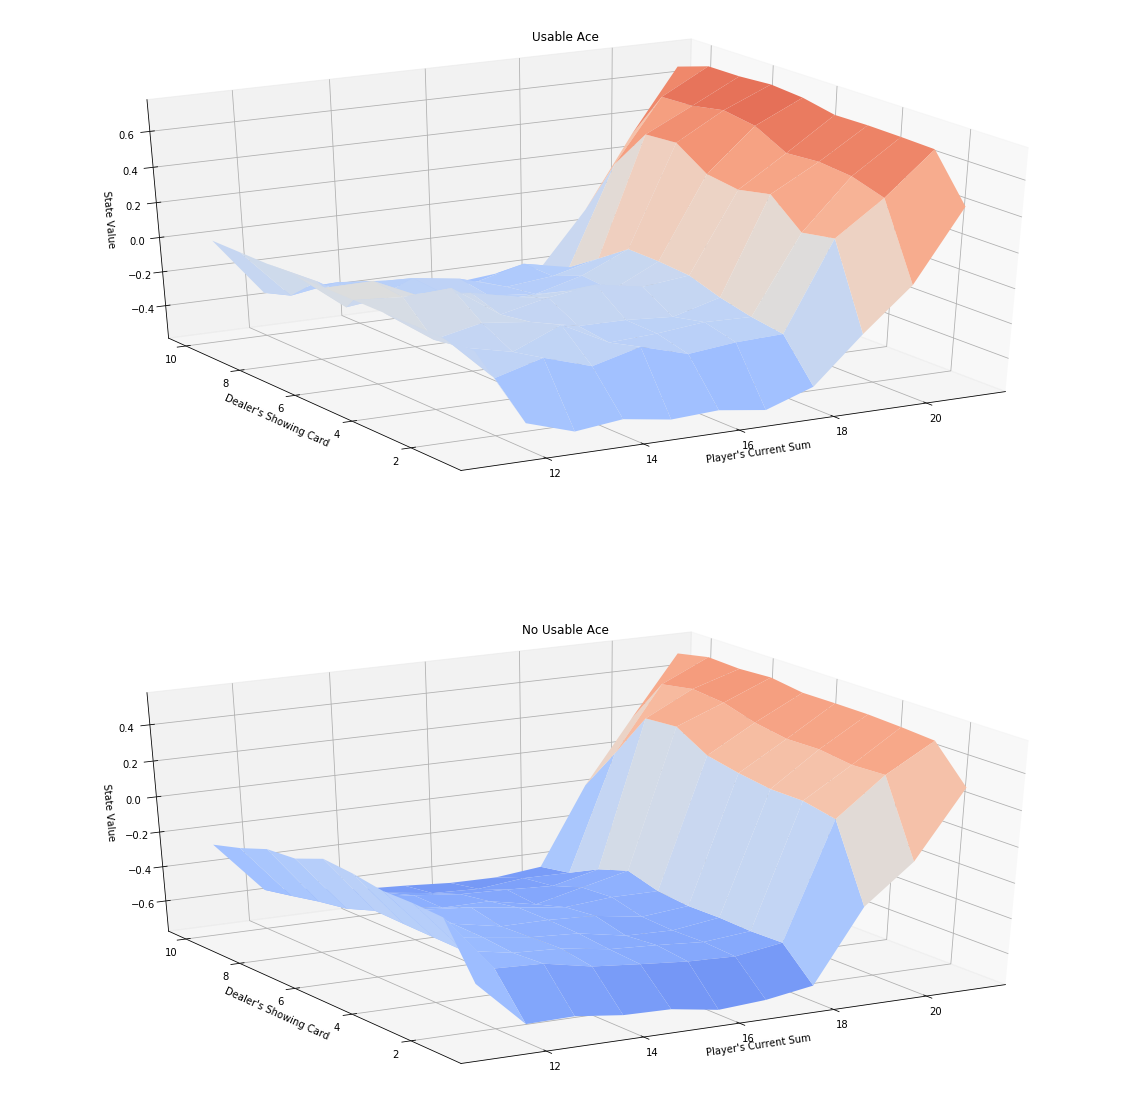

In [8]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

In [9]:
def update_Q(env, Q, episode, alpha, gamma):
    states, actions, rewards = zip(*episode)
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)])-old_Q)
    return Q

def generate_episode(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p = get_probs(Q[state], epsilon, nA)) \
        if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done: 
            break
    return episode
        
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA)*epsilon/nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon/nA)
    return policy_s

In [10]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start = 1.0, eps_decay = .99999, eps_min = 0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode(env, Q, epsilon, nA)
        Q = update_Q(env, Q, episode, alpha, gamma)
            
    policy = dict((k, np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [93]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

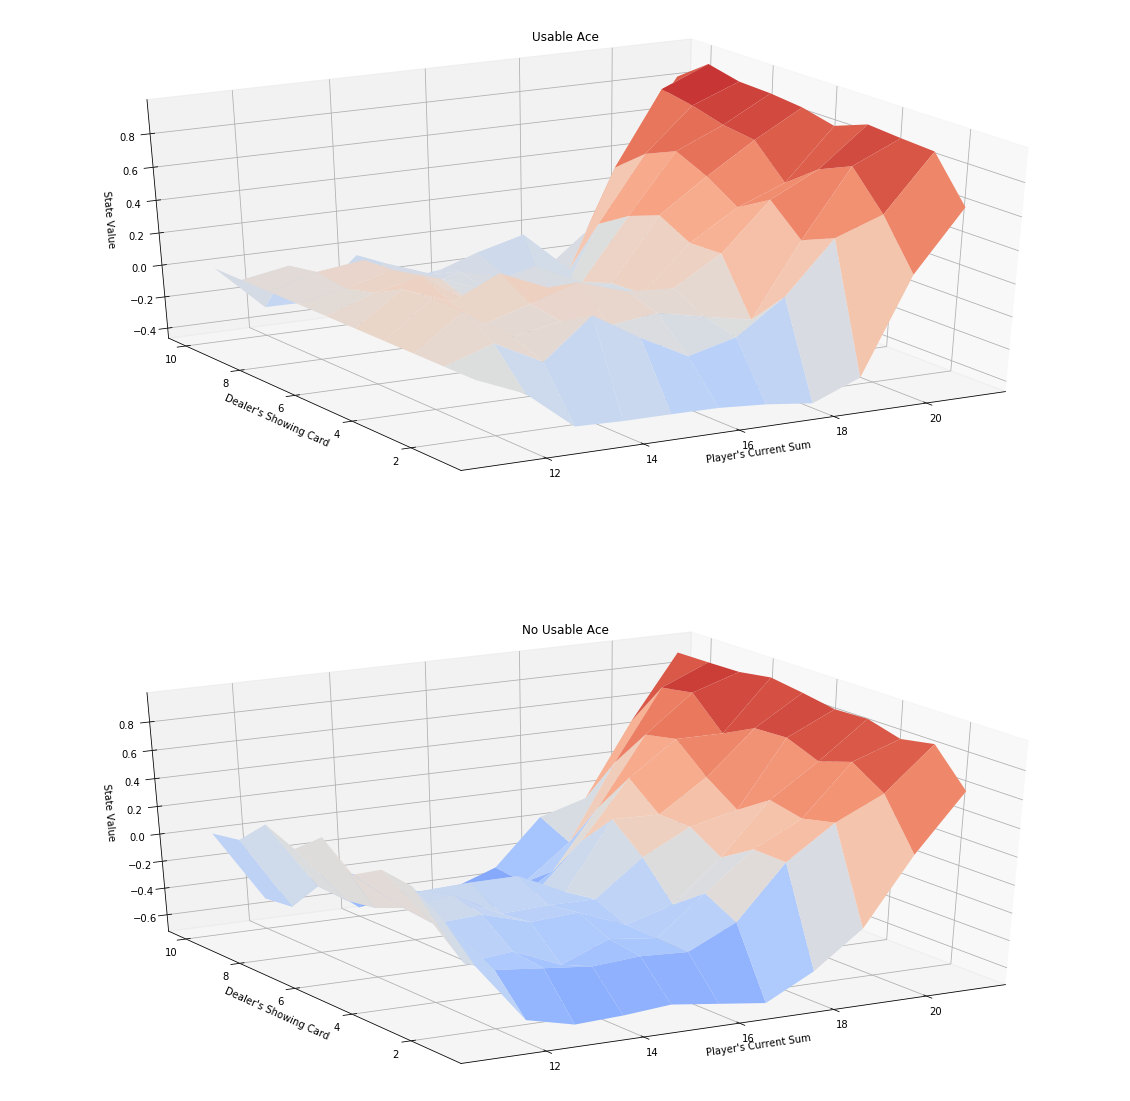

In [94]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

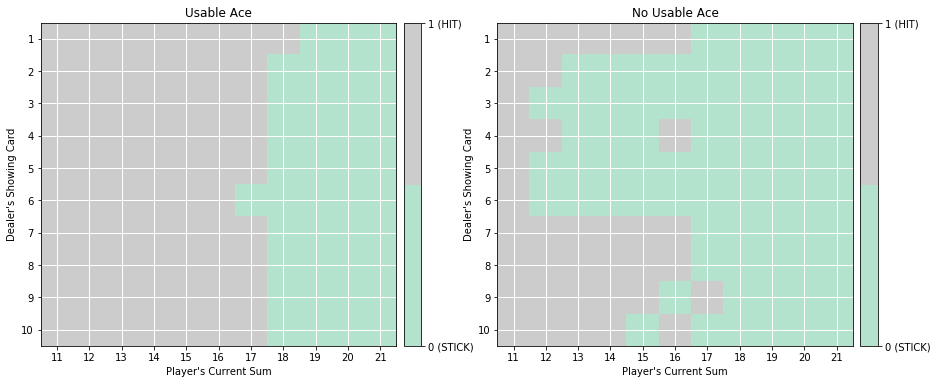

In [95]:
# plot the policy
plot_policy(policy)